In [2]:
!pip install yfinance

In [3]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3e285bbeed8b529187d4ebcb5a5a3980ca68a60eead8ce9b88a38c4da5fdf981
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import ta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

**Data Set Loading and Preprocessing**

In [24]:
# Load Amazon stock data
ticker_symbol = 'AMZN'
start_date = '2020-01-01'
end_date = '2024-01-01'
interval = '1d'

stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [25]:
# Calculate Technical Indicators
stock_data['SMA'] = ta.trend.sma_indicator(stock_data['Close'], window=14)
stock_data['EMA'] = ta.trend.ema_indicator(stock_data['Close'], window=14)
stock_data['RSI'] = ta.momentum.rsi(stock_data['Close'], window=14)
stock_data['BB_upper'] = ta.volatility.bollinger_hband(stock_data['Close'])
stock_data['BB_lower'] = ta.volatility.bollinger_lband(stock_data['Close'])
stock_data['MACD'] = ta.trend.macd(stock_data['Close'])
stock_data['ATR'] = ta.volatility.average_true_range(stock_data['High'], stock_data['Low'], stock_data['Close'])

# Include Volume as a feature
stock_data['Volume'] = stock_data['Volume']

# Calculate Volatility Measures
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
stock_data['Price_Range'] = stock_data['High'] - stock_data['Low']

# Include Lagged Features
stock_data['Lagged_Close_1'] = stock_data['Close'].shift(1)
stock_data['Lagged_RSI_1'] = stock_data['RSI'].shift(1)

# Include Calendar Features
stock_data['Day_of_Week'] = stock_data.index.dayofweek
stock_data['Month'] = stock_data.index.month

In [26]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI,BB_upper,BB_lower,MACD,ATR,Daily_Return,Price_Range,Lagged_Close_1,Lagged_RSI_1,Day_of_Week,Month
Date,,,,,,,,,,,,,,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.693001,NaN,NaN,3,1
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.012139,1.084999,94.900497,NaN,4,1
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.014886,2.184502,93.748497,NaN,0,1
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.002092,1.092506,95.143997,NaN,1,1
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.007809,1.228004,95.343002,NaN,2,1


In [27]:
stock_data.shape

(1006, 19)

In [28]:
# Drop rows with NaN values generated by the indicators and lagged features
stock_data.dropna(inplace=True)

# Select the columns we want to use as features
features = ['SMA', 'EMA', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'ATR',
            'Volume', 'Daily_Return', 'Price_Range',
            'Lagged_Close_1', 'Lagged_RSI_1', 'Day_of_Week', 'Month']

In [29]:
# Scale the features and the target 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[features + ['Close']])

In [30]:
# Split the data into training and testing sets
train_size_ratio = 0.8
train_size = int(len(scaled_data) * train_size_ratio)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [31]:
# Prepare data for multi-step forecasting
def create_multistep_dataset(dataset, time_step=60, forecast_horizon=5):
    X, Y = [], []
    for i in range(len(dataset) - time_step - forecast_horizon):
        X.append(dataset[i:(i + time_step), :-1])  # All features except the target
        Y.append(dataset[(i + time_step):(i + time_step + forecast_horizon), -1])  # Predict the next `forecast_horizon` days
    return np.array(X), np.array(Y)

time_step = 60
forecast_horizon = 5  # Predict the next 5 days
X_train, Y_train = create_multistep_dataset(train_data, time_step, forecast_horizon)
X_test, Y_test = create_multistep_dataset(test_data, time_step, forecast_horizon)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

**Bi-LSTM Code**

In [32]:
# Explicitly define hyperparameters and build the model
units = 512  # Number of LSTM units
dropout_rate = 0.1  # Dropout rate
learning_rate = 0.0001  # Learning rate for the optimizer
epochs = 100  # Number of epochs to train
batch_size = 16  # Batch size
activation_function = 'tanh'  # Activation function for LSTM layers
optimizer = Adam(learning_rate=learning_rate)  # Optimizer
loss_function = 'mean_squared_error'  # Loss function

In [33]:
# Model definition
model = Sequential()
model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_function)))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(units=units, return_sequences=False, activation=activation_function)))
model.add(Dropout(dropout_rate))
model.add(Dense(units=forecast_horizon))

model.compile(optimizer=optimizer, loss=loss_function)

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1088 - val_loss: 0.0040
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0

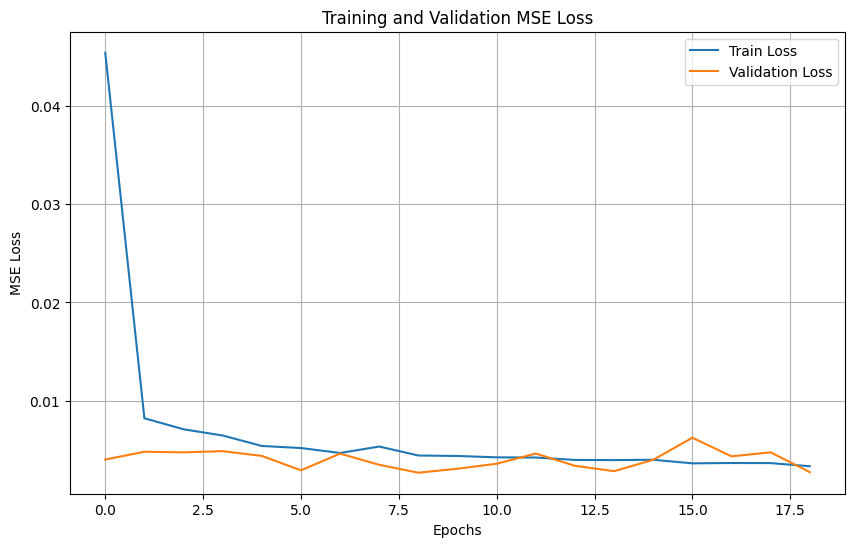

In [34]:
# After training the model, plot the MSE loss for training and validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

**Predictions**

In [35]:
# Prepare for predicting future points
# Use the last data point of the test set to predict the next `forecast_horizon` points
X_input = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

# Predict the future points
predicted_future = model.predict(X_input)

# Manually inverse transform using the scaler's min_ and scale_ for the Close price
close_min = scaler.min_[-1]
close_scale = scaler.scale_[-1]

def inverse_transform_close(scaled_values):
    return scaled_values / close_scale + close_min

predicted_future = inverse_transform_close(predicted_future).flatten()

# Prepare the actual future values for comparison
actual_future = inverse_transform_close(Y_test[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


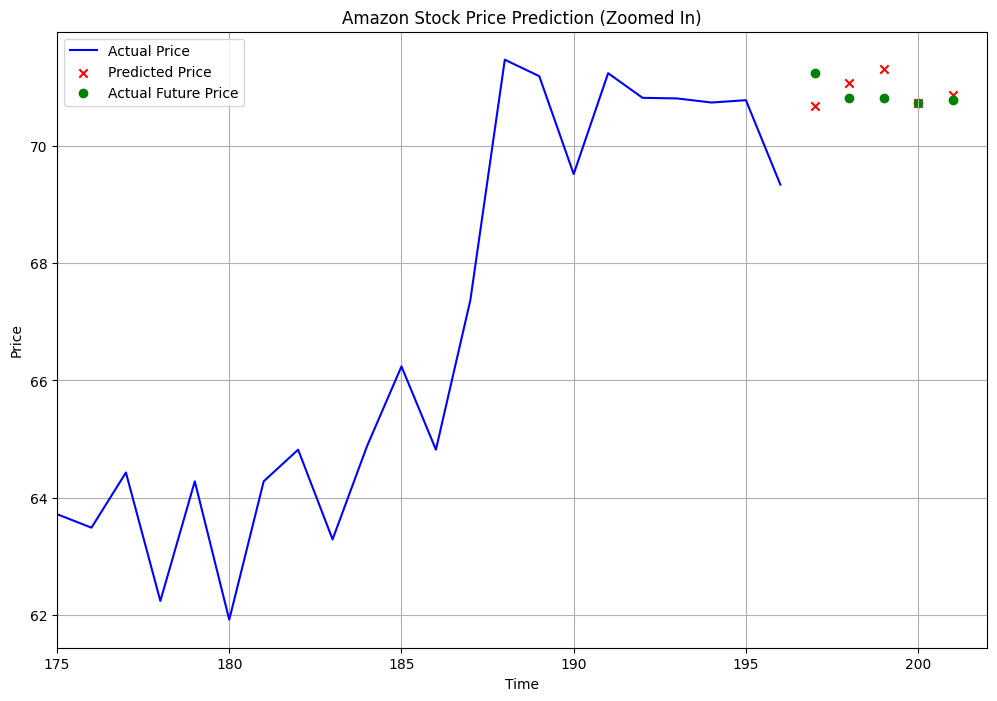

In [36]:
# Extract only the 'Close' price column (last column) from the test data
actual_prices_scaled = test_data[:, -1]  # Get the scaled 'Close' prices from test data

# Manually inverse transform the 'Close' price column
actual_prices = actual_prices_scaled / close_scale + close_min

# Set the start index for zooming in
zoom_start = 175

# Extract the portion of the actual prices from the zoom start index onwards
actual_prices_zoomed = actual_prices[zoom_start:]
test_data_zoomed = test_data[zoom_start:]

# Plot the actual 'Close' prices from the zoomed start point
plt.figure(figsize=(12, 8))
plt.plot(range(zoom_start, len(actual_prices)), actual_prices_zoomed, label='Actual Price', color='blue')

# Plot the future points predicted by the model
future_days = np.arange(len(actual_prices), len(actual_prices) + forecast_horizon)
plt.scatter(future_days, predicted_future, marker='x', color='red', label='Predicted Price')

# Plot the actual future points for comparison
plt.scatter(future_days, actual_future, marker='o', color='green', label='Actual Future Price')

# Set x-axis limits to zoom in
plt.xlim([zoom_start, len(actual_prices) + forecast_horizon])

plt.title('Amazon Stock Price Prediction (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Function to calculate accuracy metrics and confidence intervals
def evaluate_predictions(actual, predicted, confidence_level=0.95):
    # Ensure no NaN values are present in the data
    if np.isnan(actual).any() or np.isnan(predicted).any():
        return {
            'MSE': np.nan,
            'MAE': np.nan,
            'Direction Accuracy': np.nan,
            'Confidence Interval': (np.nan, np.nan)
        }

    # Calculate MSE and MAE
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)

    # Calculate the direction of price movement (up/down) if we have more than one point
    if len(actual) > 1:
        actual_direction = np.sign(np.diff(actual))
        predicted_direction = np.sign(np.diff(predicted))
        direction_accuracy = np.mean(actual_direction == predicted_direction)
    else:
        direction_accuracy = np.nan  # Not enough points to calculate direction

    # Calculate residuals (errors)
    residuals = actual - predicted

    # Check if there are enough data points to calculate a meaningful confidence interval
    if len(residuals) > 1:
        residual_mean = np.mean(residuals)
        residual_std = np.std(residuals)
        n = len(residuals)

        # Compute confidence interval for the predictions
        ci_lower, ci_upper = stats.t.interval(
            confidence_level, n-1, loc=residual_mean, scale=stats.sem(residuals))
    else:
        ci_lower, ci_upper = np.nan, np.nan  # Not enough data for confidence interval

    return {
        'MSE': mse,
        'MAE': mae,
        'Direction Accuracy': direction_accuracy,
        'Confidence Interval': (ci_lower, ci_upper)
    }

# Evaluate predictions for each day in the forecast horizon
for i in range(forecast_horizon):
    actual_day = actual_future[i]
    predicted_day = predicted_future[i]

    results = evaluate_predictions(np.array([actual_day]), np.array([predicted_day]))

    print(f"Day {i+1} - MSE: {results['MSE']:.4f}, MAE: {results['MAE']:.4f}, "
          f"Direction Accuracy: {results['Direction Accuracy']:.2%}, "
          f"Confidence Interval: {results['Confidence Interval']}")

Day 1 - MSE: 0.3058, MAE: 0.5530, Direction Accuracy: nan%, Confidence Interval: (nan, nan)
Day 2 - MSE: 0.0611, MAE: 0.2471, Direction Accuracy: nan%, Confidence Interval: (nan, nan)
Day 3 - MSE: 0.2581, MAE: 0.5080, Direction Accuracy: nan%, Confidence Interval: (nan, nan)
Day 4 - MSE: 0.0001, MAE: 0.0103, Direction Accuracy: nan%, Confidence Interval: (nan, nan)
Day 5 - MSE: 0.0072, MAE: 0.0851, Direction Accuracy: nan%, Confidence Interval: (nan, nan)


In [38]:
# Example: Evaluate predictions over the full forecast horizon (5 days)
actual_sequence = actual_future[:forecast_horizon]
predicted_sequence = predicted_future[:forecast_horizon]

# Evaluate predictions over a sequence of days
results = evaluate_predictions(actual_sequence, predicted_sequence)

print(f"Overall Evaluation for {forecast_horizon} Days - MSE: {results['MSE']:.4f}, MAE: {results['MAE']:.4f}, "
      f"Direction Accuracy: {results['Direction Accuracy']:.2%}, "
      f"Confidence Interval: {results['Confidence Interval']}")

Overall Evaluation for 5 Days - MSE: 0.1264, MAE: 0.2807, Direction Accuracy: 50.00%, Confidence Interval: (-0.5430191334738431, 0.43222548432311286)


In [39]:
from tensorflow.keras.models import load_model

In [40]:
# Save Model
model.save('bi_lstm_amzn.keras')

In [41]:
import os
print(os.getcwd())  # This will print the current working directory

/content
